### Import necessary libraries

In [38]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from ib_insync import *
from datetime import datetime
import time
import os

SYMBOL = 'QQQ'
DATA_FILE = f'../data/{SYMBOL}_5min.csv'
DOWNLOAD_NEW_DATA = False  # Set to True to force download from IBKR
STARTING_CAPITAL = 10000

### Data Ingestion

In [39]:
async def download_data_from_ib():
    # Start the connection to TWS or IB Gateway
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7497, clientId=1)

    # Define the contract
    contract = Stock(SYMBOL, 'SMART', 'USD')

    all_data = []
    end_date = datetime.now()

    # Download 20 years data
    for i in range(1, 41):
        endDateTime = end_date.strftime('%Y%m%d %H:%M:%S')

        # Request 5-minute historical data
        bars = ib.reqHistoricalData(
            contract,
            endDateTime=endDateTime,     # data up to this timestamp
            durationStr='6 M',           # 6 months per request
            barSizeSetting='5 mins',     # timeframe 5min
            whatToShow='TRADES',         
            useRTH=True,                 # regular trading hours only
            formatDate=1
        )

        if bars:
            # Convert the response to a DataFrame
            df = util.df(bars)
            print(f"Fetched {len(df)} bars ending on {df['date'].iloc[-1]}")
            all_data.append(df)
            end_date = pd.to_datetime(df['date'].iloc[0])
        
        time.sleep(1)

    ib.disconnect()

    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        final_df = final_df.drop_duplicates(subset=['date'], keep='first')
        final_df = final_df.sort_values('date').reset_index(drop=True)
        return final_df
    
    return pd.DataFrame()

# --- Loading Logic ---
if DOWNLOAD_NEW_DATA or not os.path.exists(DATA_FILE):
    df = await download_data_from_ib()
    if not df.empty:
        # Create the 'data' folder if it doesn't exist
        os.makedirs('data', exist_ok=True)
        df.to_csv(DATA_FILE, index=False)
        print(f"Data saved to {DATA_FILE}")
else:
    print(f"Loading local data from {DATA_FILE}...")
    df = pd.read_csv(DATA_FILE)

df['date'] = pd.to_datetime(df['date'], utc=True).dt.tz_convert('America/New_York')


Loading local data from ../data/QQQ_5min.csv...


### Feature Engineering


In [40]:
# Calculate indicators using Pandas TA
df['ATR_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)
df['SMA_200'] = ta.sma(df['close'], length=200)
df['WILLR_10'] = ta.willr(df['high'], df['low'], df['close'], length=10)

# Remove initial NaN values caused by the SMA200 calculation
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,date,open,high,low,close,volume,average,barCount,ATR_14,SMA_200,WILLR_10
0,2009-12-21 13:05:00-05:00,44.99,44.99,44.96,44.99,320800.0,44.976,513,0.052403,44.27625,-68.421053
1,2009-12-21 13:10:00-05:00,44.98,45.01,44.95,44.97,961800.0,44.969,1090,0.052946,44.28070,-76.470588
2,2009-12-21 13:15:00-05:00,44.96,44.97,44.93,44.95,234400.0,44.951,434,0.052021,44.28460,-83.333333
3,2009-12-21 13:20:00-05:00,44.96,44.97,44.95,44.97,418200.0,44.965,538,0.049734,44.28860,-60.000000
4,2009-12-21 13:25:00-05:00,44.97,44.99,44.96,44.99,201000.0,44.967,369,0.048325,44.29290,-40.000000


### Backtest


In [41]:
def ibkr_commission(shares):
    total_fees = shares * 0.005
    return total_fees

def calculate_position_size(entry_price, stop_loss, account_size, risk_per_trade_pct, max_risk_dollars, leverage=4):
    """
    Calculate the number of contracts (or shares) to buy, taking into account:
    - risk per trade as a percentage,
    - leverage,
    - maximum allowed absolute loss in dollars.
    """

    # Risk per contract
    R = abs(entry_price - stop_loss)
    if R == 0 or R < 0.01:  # minimal symbolic risk to avoid division by zero
        return 0

    risk_dollars = account_size * risk_per_trade_pct
    allowed_risk = min(risk_dollars, max_risk_dollars)
    risk_based_size = allowed_risk / R
    leverage_based_size = (account_size * leverage) / entry_price
    position_size = int(min(risk_based_size, leverage_based_size))

    return position_size, R * position_size

def run_backtest(df, investment, risk_per_trade_pct, atr_multiplier, max_risk_dollars):
    equity = investment
    trades = []
    
    in_position = False
    entry_price = 0
    entry_date = None
    no_of_shares = 0
    trailing_stop_price = 0
    dollar_risk = 0
    entry_idx = 0
    fees = 0

    for i in range(1, len(df)):
        
        # --- EXIT LOGIC ---
        if in_position:
            exit_triggered = False
            exit_reason = ""

            if df['low'].iloc[i] <= trailing_stop_price:
                exit_triggered = True
                exit_reason = "TRAILING_STOP"
                exit_price = trailing_stop_price
            if df['WILLR_10'].iloc[i] > -20 and df['close'].iloc[i] < df['SMA_200'].iloc[i]:
                exit_triggered = True
                exit_reason = "WILLR_SMA"
                exit_price = df['close'].iloc[i]

            if exit_triggered:
                pnl = (exit_price - entry_price) * no_of_shares - fees
                equity += (no_of_shares * exit_price) - fees
                rr = pnl / dollar_risk
                
                trades.append({
                    "entry_date": entry_date,
                    "exit_date": df["date"].iloc[i],
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "pnl": round(pnl, 2),
                    "R:R": rr,
                    "shares": no_of_shares,
                    "equity": equity,
                    "atr_at_entry": df['ATR_14'].iloc[entry_idx-1],
                    "sma200_at_entry": df['SMA_200'].iloc[entry_idx-1],
                    "willr10_at_entry": df['WILLR_10'].iloc[entry_idx-1],
                    "exit_reason": exit_reason,
                    "fees": fees,
                })
                
                in_position = False
                no_of_shares = 0
                continue # Skip to the next loop iteration after closing the position

            # Calculate potential new stop and update only if higher
            potential_stop = round(df['close'][i] - (df['ATR_14'].iloc[i] * atr_multiplier), 2)
            trailing_stop_price = max(trailing_stop_price, potential_stop)
        # --- ENTRY LOGIC ---
        if not in_position:
            if df['WILLR_10'].iloc[i] < -80 and df['close'].iloc[i] > df['SMA_200'].iloc[i]:
                entry_date = df['date'].iloc[i]

                entry_price = df['open'].iloc[i+1]
                
                atr_value = df['ATR_14'].iloc[i]
                if atr_value <= 0: 
                    continue # Avoid division by zero if ATR is zero
                
                # --- POSITION SIZING BASED ON ATR AND RISK ---
                risk_per_share = atr_value * atr_multiplier
                # Set initial stop loss
                trailing_stop_price = round(entry_price - risk_per_share, 2)

                no_of_shares, dollar_risk = calculate_position_size(
                    entry_price=entry_price,
                    stop_loss=trailing_stop_price,
                    account_size=equity,
                    risk_per_trade_pct=risk_per_trade_pct,
                    max_risk_dollars=max_risk_dollars,
                    leverage=4
                )

                if no_of_shares > 0:
                    in_position = True
                    fees = ibkr_commission(no_of_shares) * 2
                    entry_idx = i + 1
                
                # Execute trade
                equity -= (no_of_shares * entry_price) 
                

    # Close position if still open at the end
    if in_position:
        equity += (no_of_shares * df['close'].iloc[i])

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)

    print(f'EARNING: ${earning} ; ROI: {roi}%')
    return pd.DataFrame(trades)
   
# Execute backtest
trades_df = run_backtest(df, STARTING_CAPITAL, risk_per_trade_pct=0.02, atr_multiplier=10, max_risk_dollars=30000)
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'], utc=True).dt.tz_convert('America/New_York')
trades_df.head()

EARNING: $516341.56 ; ROI: 5163.42%


,entry_date,exit_date,entry_price,exit_price,pnl,R:R,shares,equity,atr_at_entry,sma200_at_entry,willr10_at_entry,exit_reason,fees
0,2009-12-21 13:15:00-05:00,2009-12-23 14:40:00-05:00,44.96,45.26,111.36,0.557692,384,10111.36,0.052021,44.28460,-83.333333,TRAILING_STOP,3.84
1,2009-12-23 15:30:00-05:00,2009-12-28 14:25:00-05:00,45.47,45.94,244.72,1.210526,532,10356.08,0.038241,45.23425,-83.333333,TRAILING_STOP,5.32
2,2009-12-28 14:40:00-05:00,2009-12-30 11:45:00-05:00,45.98,46.06,38.15,0.184211,545,10394.23,0.037850,45.73970,-82.608696,WILLR_SMA,5.45
3,2009-12-31 10:00:00-05:00,2009-12-31 12:05:00-05:00,46.15,46.06,-50.70,-0.243902,507,10343.53,0.040951,46.09255,-86.666667,WILLR_SMA,5.07
4,2010-01-04 10:15:00-05:00,2010-01-06 13:00:00-05:00,46.29,46.27,-7.95,-0.038462,265,10335.58,0.077998,46.07190,-88.235294,WILLR_SMA,2.65


#### Plot: Strategy vs Benchmark


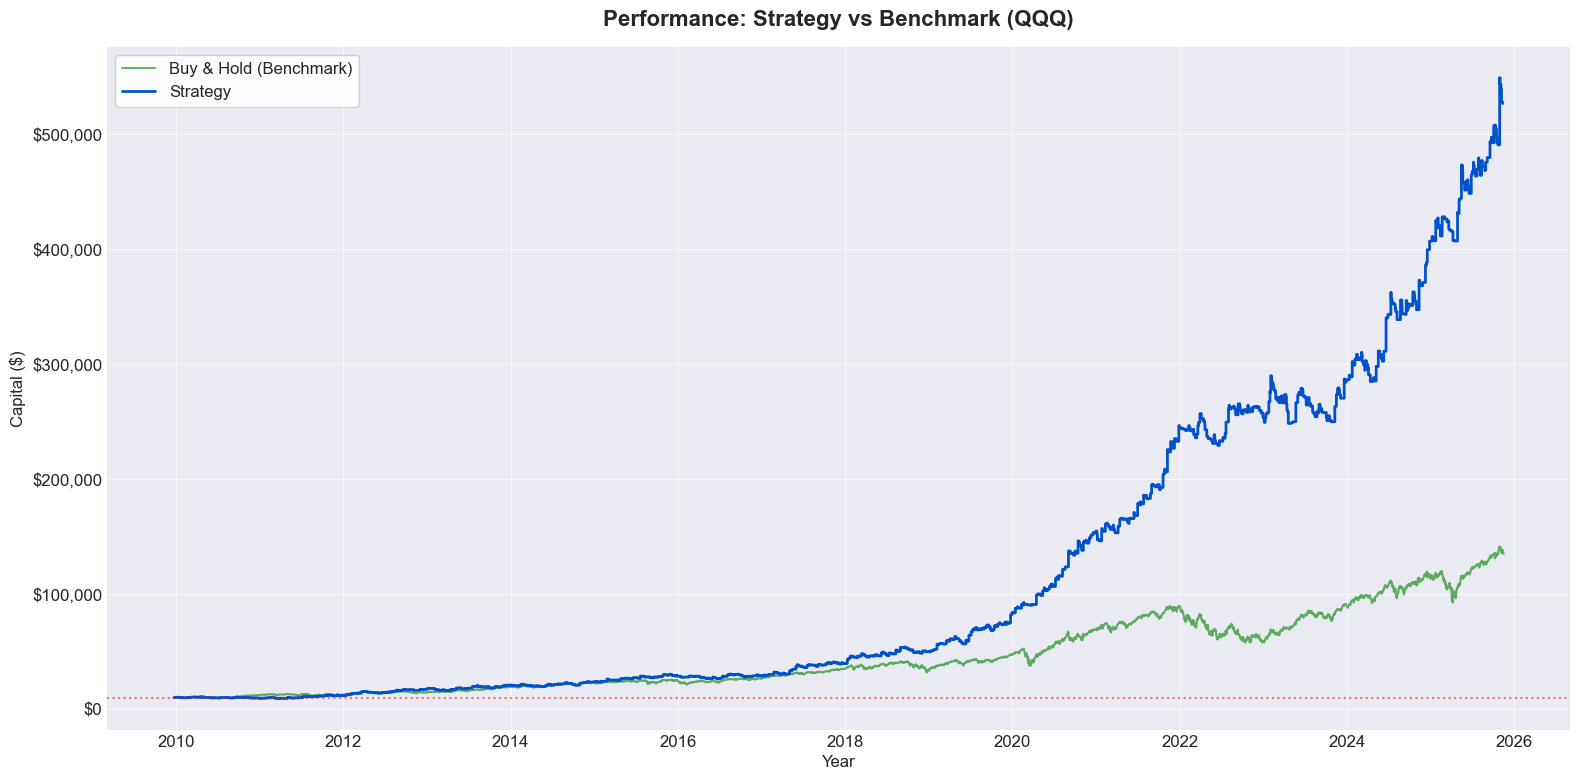

In [42]:
import matplotlib.pyplot as plt

# Resample Buy & Hold to Daily timeframe for the chart
bh_resampled = df.resample('1D', on='date')['close'].last().dropna()
shares_bh = STARTING_CAPITAL / df.iloc[0]['close']
bh_equity = bh_resampled * shares_bh

# Chart creation
plt.figure(figsize=(16, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Plot Buy & Hold
plt.plot(bh_equity.index, bh_equity, 
         color='green', alpha=0.6, linewidth=1.5, label='Buy & Hold (Benchmark)')

# Plot Strategy
plt.step(trades_df['exit_date'], trades_df['equity'], 
         where='post', color='#0052CC', linewidth=2, label='Strategy')

# Initial Capital Line
plt.axhline(y=STARTING_CAPITAL, color='red', linestyle=':', alpha=0.5)

# Formatting
plt.title('Performance: Strategy vs Benchmark (QQQ)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Capital ($)', fontsize=12)
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='white', framealpha=0.9)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()


### Stats

In [43]:
import quantstats as qs

# Normalize Dates
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'], utc=True).dt.tz_convert(None)
start_date = df['date'].iloc[0].tz_convert(None)

# Build daily equity curve
equity_series = trades_df.set_index('exit_date')['equity']

equity_series[start_date] = STARTING_CAPITAL
equity_series = equity_series.sort_index()

# Resample to daily frequency, forward-filling gaps between trades
equity_daily = equity_series.resample('1D').last().ffill()

# Download Benchmark (QQQ)
benchmark = qs.utils.download_returns('QQQ')
benchmark = benchmark.loc[equity_daily.index.min() : equity_daily.index.max()]

# Align Strategy Calendar to Benchmark Calendar
equity_daily_aligned = equity_daily.reindex(benchmark.index).ffill()

# Compute Daily Returns
returns = equity_daily_aligned.pct_change().fillna(0)

# Generate QuantStats Performance Report
qs.reports.metrics(returns, benchmark=benchmark)


                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2009-12-21   2009-12-21
End Period           2025-11-12   2025-11-12
Risk-Free Rate       0.0%         0.0%
Time in Market       100.0%       29.0%

Cumulative Return    1,478.02%    5,163.42%
CAGR﹪               18.99%       28.37%

Sharpe               0.95         1.46
Prob. Sharpe Ratio   99.99%       100.0%
Sortino              1.34         3.79
Sortino/√2           0.95         2.68
Omega                1.7          1.7

Max Drawdown         -35.12%      -14.28%
Max DD Date          2022-11-03   2023-04-20
Max DD Period Start  2021-12-28   2023-02-06
Max DD Period End    2023-12-12   2024-01-10
Longest DD Days      715          442

Gain/Pain Ratio      0.19         0.7
Gain/Pain (1M)       1.27         2.28

Payoff Ratio         0.44         2.19
Profit Factor        1.19         1.7
Common Sense Ratio   1.13         2.51
CPC Index            0.3          1.52
Tail Ratio 